# **Metric Learning Exercice**

This exercise is split in 2 tasks. 

In the first task we will study how Metric Learning 

*   In the first task we will study how Metric Learning learns to separate data in an embedding space. For this task we will split the data considering its garment categories and we will basically observe the result of training a classifier and using Siamese or Triplet Networks on them with or without Negative Mining.

*   In the second task, based on the results of first task, we will chose an arquitecture to train a system to do image retrieval, the difference is that in this case the training will be done to split images that belong to same item and 
not just to the same class. This case is more useful but would be very hard to see and learn the distribution that the embedding have.

For these 2 tasks, two main github projects have been used and modify to adapt it to the new demands:

*   https://github.com/adambielski/siamese-triplet
*   https://github.com/open-mmlab/mmfashion

They have been forked and the changes made to them can be seen under these 2 forks under the branch named MetricLearning:

*   https://github.com/JoanFM/siamese-triplet.git
*   https://github.com/JoanFM/mmfashion.git

In the exercise it was required to try to get high dimensional embeddings and project them to a low dimensional space, this is left out of the scope of this notebook because we considered that we would need to run too many models and combinations, and the exercise would get hard to follow.

Clone from slightly changed versions from personal fork the projects to access siamese and triplets training and processing and loading off MMFashion dataset

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [0]:
!rm -rf siamese-triplet/
!git clone -b MetricLearning https://github.com/JoanFM/siamese-triplet.git
!rm -rf mmfashion/
!git clone -b MetricLearning https://github.com/JoanFM/mmfashion.git
!unzip gdrive/My\ Drive/MetricLearning/data/In-shop/img.zip

Install mmfashion to the system

In [0]:
!cd mmfashion; sudo pip uninstall mmfashion
!cd mmfashion; sudo python setup.py install

#**Task 1 - Metric Learning**

In [0]:
import torch
import os
import sys
import mmfashion
from mmfashion.datasets import InShopDataset
from mmfashion.datasets.loader import build_dataloader
working_dir = os.getcwd()
sys.path.append(working_dir)
sys.path.append(os.path.join(working_dir, 'siamese-triplet'))

### Prepare Dataset
Working with the In-Shop dataset from mmfashion, please check https://github.com/open-mmlab/mmfashion/blob/master/docs/dataset/IN_SHOP_DATASET.md

In [0]:
img_path = '.'
in_shop_path = os.path.join(working_dir, 'gdrive/My Drive/MetricLearning/data/In-shop')
annotations_path = os.path.join(in_shop_path, 'Anno')
models_path =  os.path.join(working_dir, 'gdrive/My Drive/MetricLearning/models')

In [0]:
batch_size = 64
class_mapping = {
    'Denim': 0,
    'Jackets_Vests': 1,
    'Pants': 2,
    'Shirts_Polos': 3,
    'Shorts': 4,
    'Suiting': 5,
    'Sweaters': 6,
    'Sweatshirts_Hoodies': 7,
    'Tees_Tanks': 8,
    'Blouses_Shirts': 9,
    'Cardigans': 10,
    'Dresses': 11,
    'Graphic_Tees': 12,
    'Jackets_Coats': 13,
    'Leggings': 14,
    'Rompers_Jumpsuits': 15,
    'Skirts': 16
}

train_dataset = InShopDataset(img_path=img_path,
                              img_file=os.path.join(annotations_path,'train_img.txt'),
                              label_file=os.path.join(annotations_path,'train_labels.txt'),
                              id_file=os.path.join(annotations_path,'train_id.txt'),
                              bbox_file=os.path.join(annotations_path,'train_bbox.txt'),
                              landmark_file=os.path.join(annotations_path,'train_landmarks.txt'),
                              img_size=[256, 256],
                              class_mapping=class_mapping)

gallery_dataset = InShopDataset(img_path=img_path,
                              img_file=os.path.join(annotations_path,'gallery_img.txt'),
                              label_file=os.path.join(annotations_path,'gallery_labels.txt'),
                              id_file=os.path.join(annotations_path,'gallery_id.txt'),
                              bbox_file=os.path.join(annotations_path,'gallery_bbox.txt'),
                              landmark_file=os.path.join(annotations_path,'gallery_landmarks.txt'),
                              img_size=[256, 256],
                              class_mapping=class_mapping)

query_dataset = InShopDataset(img_path=img_path,
                              img_file=os.path.join(annotations_path,'query_img.txt'),
                              label_file=os.path.join(annotations_path,'query_labels.txt'),
                              id_file=os.path.join(annotations_path,'query_id.txt'),
                              bbox_file=os.path.join(annotations_path,'query_bbox.txt'),
                              landmark_file=os.path.join(annotations_path,'query_landmarks.txt'),
                              img_size=[256, 256],
                              class_mapping=class_mapping)

train_dataloader = build_dataloader(dataset=train_dataset,
                                    imgs_per_gpu=batch_size,
                                    workers_per_gpu=1,
                                    num_gpus=1,
                                    shuffle=True)

gallery_dataloader = build_dataloader(dataset=gallery_dataset,
                                    imgs_per_gpu=batch_size,
                                    workers_per_gpu=1,
                                    num_gpus=1,
                                    shuffle=True)

query_dataloader = build_dataloader(dataset=query_dataset,
                                    imgs_per_gpu=batch_size,
                                    workers_per_gpu=1,
                                    num_gpus=1,
                                    shuffle=False)

n_classes = 17

### Utils to extract and plot embeddings in low dimensional space

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
cuda = torch.cuda.is_available()
print(cuda)
transform = 'TSNE'

mmfashion_classes = [] 
for key in class_mapping.keys(): 
  mmfashion_classes.append(key) 
    
colors = cm.get_cmap('tab20', 17).colors

def plot_embeddings(embeddings, target, transform=None):
  if len(embeddings[0]) > 2:
    if (transform is 'TSNE'):
      embeddings = TSNE(n_components=2).fit_transform(embeddings)
      plt.figure(figsize=(10,10))
    elif(transform is 'PCA'):
      pca = PCA(n_components=2)
      pca.fit(embeddings)
      embeddings = pca.transform(embeddings)
      plt.figure(figsize=(10,10))
    for i in range(n_classes):
      inds = np.where(target==i)[0]
      plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    plt.legend(mmfashion_classes)   
  else:
    plt.figure(figsize=(10,10))
    for i in range(n_classes):
      inds = np.where(target==i)[0]
      plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    plt.legend(mmfashion_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
      model.eval()
      embeddings = np.zeros((len(dataloader.dataset), model.embedding_net.out_dimensions))
      labels = np.zeros(len(dataloader.dataset))
      k = 0
      for loader in dataloader:
        images = loader['img']
        target = loader['target']
        if cuda:
          images = images.cuda()
        embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
        labels[k:k+len(images)] = target.numpy()
        k += len(images)
    return embeddings, labels

True


### Utils to train and evaluate kNN classification using embeddings taken out from training

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

def fitAndEvaluateKNNAlgorithm(preds, labels, test_preds, test_labels):
  knn = KNeighborsClassifier(n_neighbors=100)
  knn.fit(preds, labels)
  y_pred = knn.predict(test_preds)
  return metrics.accuracy_score(test_labels, y_pred)

### Utils to compute and plot confusion matrix

In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

@torch.no_grad()
def get_all_preds(model, loader):
  with torch.no_grad():
    model.eval()
    all_preds = torch.tensor([])
    for loader in enumerate(loader):
      batch_idx = loader[0]
      if type(loader[1]) is dict:
        data = loader[1]['img']
      else:
        (data, _) = loader[1]
    
      if not type(data) in (tuple, list):
        data = (data,)
      if cuda:
        data = tuple(d.cuda() for d in data)

      preds = model(*data)
      all_preds = all_preds.cuda()
      all_preds = torch.cat(
          (all_preds, preds)
          , dim=0
      )
    return all_preds

def compute_confusion_matrix(targets, predictions):
  stacked = torch.stack(
    (
        targets
        ,predictions.argmax(dim=1)
    )
    ,dim=1
  )
  cmt = torch.zeros(n_classes, n_classes, dtype=torch.int64)
  for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1
  return cmt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')
  fig = plt.figure(figsize=(20, 20))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  plt.title(label="Confusion Matrix")

  thresh = cm.max() / 4.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')


## Baseline classification model
First approach and interesting to see is how features are embedded when a network is trained for a classification task. It is really different from the metric learning task but can provide us some insights and better understanding of the tasks to come.

The Classification model will be trained using an Embedding Net that will compute embedding to 3 different output dimensions to test (2, 16 or 32).

The first embedding will be easily visualized, for the ones with 16 or 32 dimensions, some dimensionality reduction technique will be used to be able to plot it in 2D or 3D

### Train classification

In [0]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
cuda = torch.cuda.is_available()
from networks import MMFashionEmbeddingResNet50, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = MMFashionEmbeddingResNet50(out_dimensions=2)
classification_model_2d = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
  classification_model_2d.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(classification_model_2d.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
path = os.path.join(models_path,'classification_2d.model')
from trainer import fit
fit(train_dataloader, gallery_dataloader, classification_model_2d, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])
torch.save(classification_model_2d.state_dict(), path)

Train: [0/25882 (0%)]	Loss: 2.926073	Accuracy: 0.0
Train: [3200/25882 (12%)]	Loss: 3.782851	Accuracy: 16.11519607843137
Train: [6400/25882 (25%)]	Loss: 2.534548	Accuracy: 22.076113861386137
Train: [9600/25882 (37%)]	Loss: 2.345322	Accuracy: 23.623758278145694
Train: [12800/25882 (49%)]	Loss: 2.245389	Accuracy: 24.33924129353234
Train: [16000/25882 (62%)]	Loss: 2.133336	Accuracy: 25.622509960159363
Train: [19200/25882 (74%)]	Loss: 2.059854	Accuracy: 26.8843438538206
Train: [22400/25882 (86%)]	Loss: 2.008448	Accuracy: 27.90687321937322
Train: [25600/25882 (99%)]	Loss: 2.023964	Accuracy: 28.46399625935162
Epoch: 1/20. Train set: Average loss: 2.3883	Accuracy: 28.514025191252607
Epoch: 1/20. Validation set: Average loss: 2.0167	Accuracy: 33.80907072629242
Train: [0/25882 (0%)]	Loss: 1.920083	Accuracy: 35.9375
Train: [3200/25882 (12%)]	Loss: 2.013419	Accuracy: 32.84313725490196
Train: [6400/25882 (25%)]	Loss: 1.962282	Accuracy: 33.89542079207921
Train: [9600/25882 (37%)]	Loss: 1.932498	Accu

### Plot embeddings


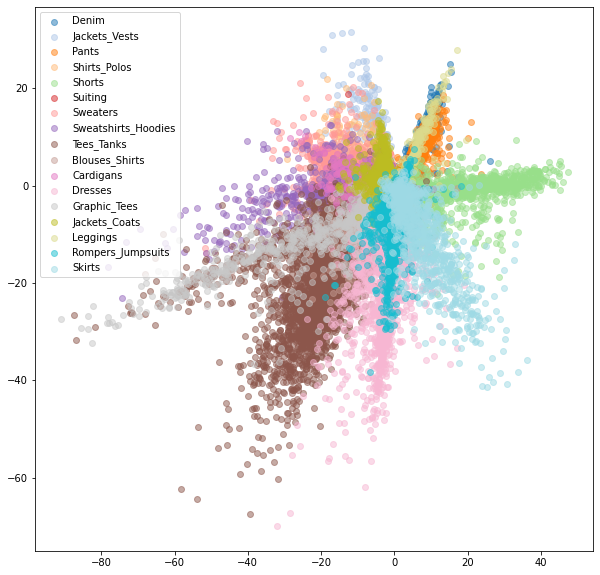

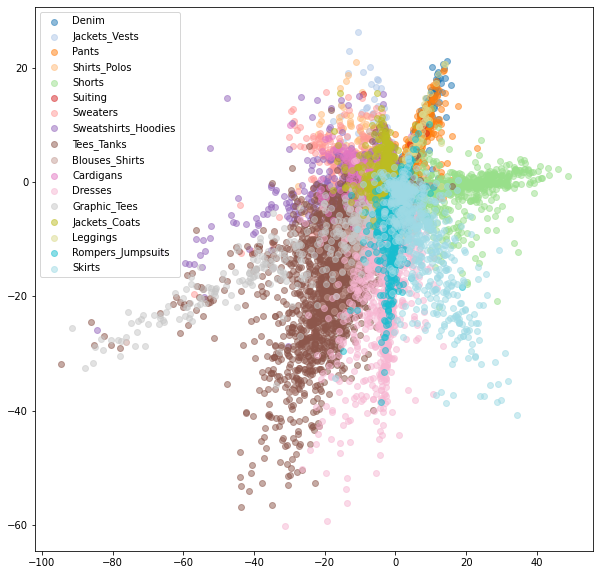

In [0]:
path = os.path.join(models_path,'classification_2d.model')
embedding_net = MMFashionEmbeddingResNet50(out_dimensions=2)
classification_model_2d = ClassificationNet(embedding_net, n_classes=n_classes)
classification_model_2d.load_state_dict(torch.load(path))
classification_model_2d.eval()
if cuda:
  classification_model_2d.cuda()
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_dataloader, classification_model_2d)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(query_dataloader, classification_model_2d)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

We can see more or less the distribution of embeddings expected and seen in other examples how classification and the use of Cross Entropy Loss distributes the embeddings. 
The effect is not great because the accuracy was just around 60%

The amount of classes makes it a little difficult to see if the classes that are forming an angle close to each other are 'related' or not. Although for instance it seems that Dresses and Romper JumpSuits seem to be closed and makes sense. Also pants and leggings point in the same direction

### Confusion matrix

Confusion matrix, without normalization


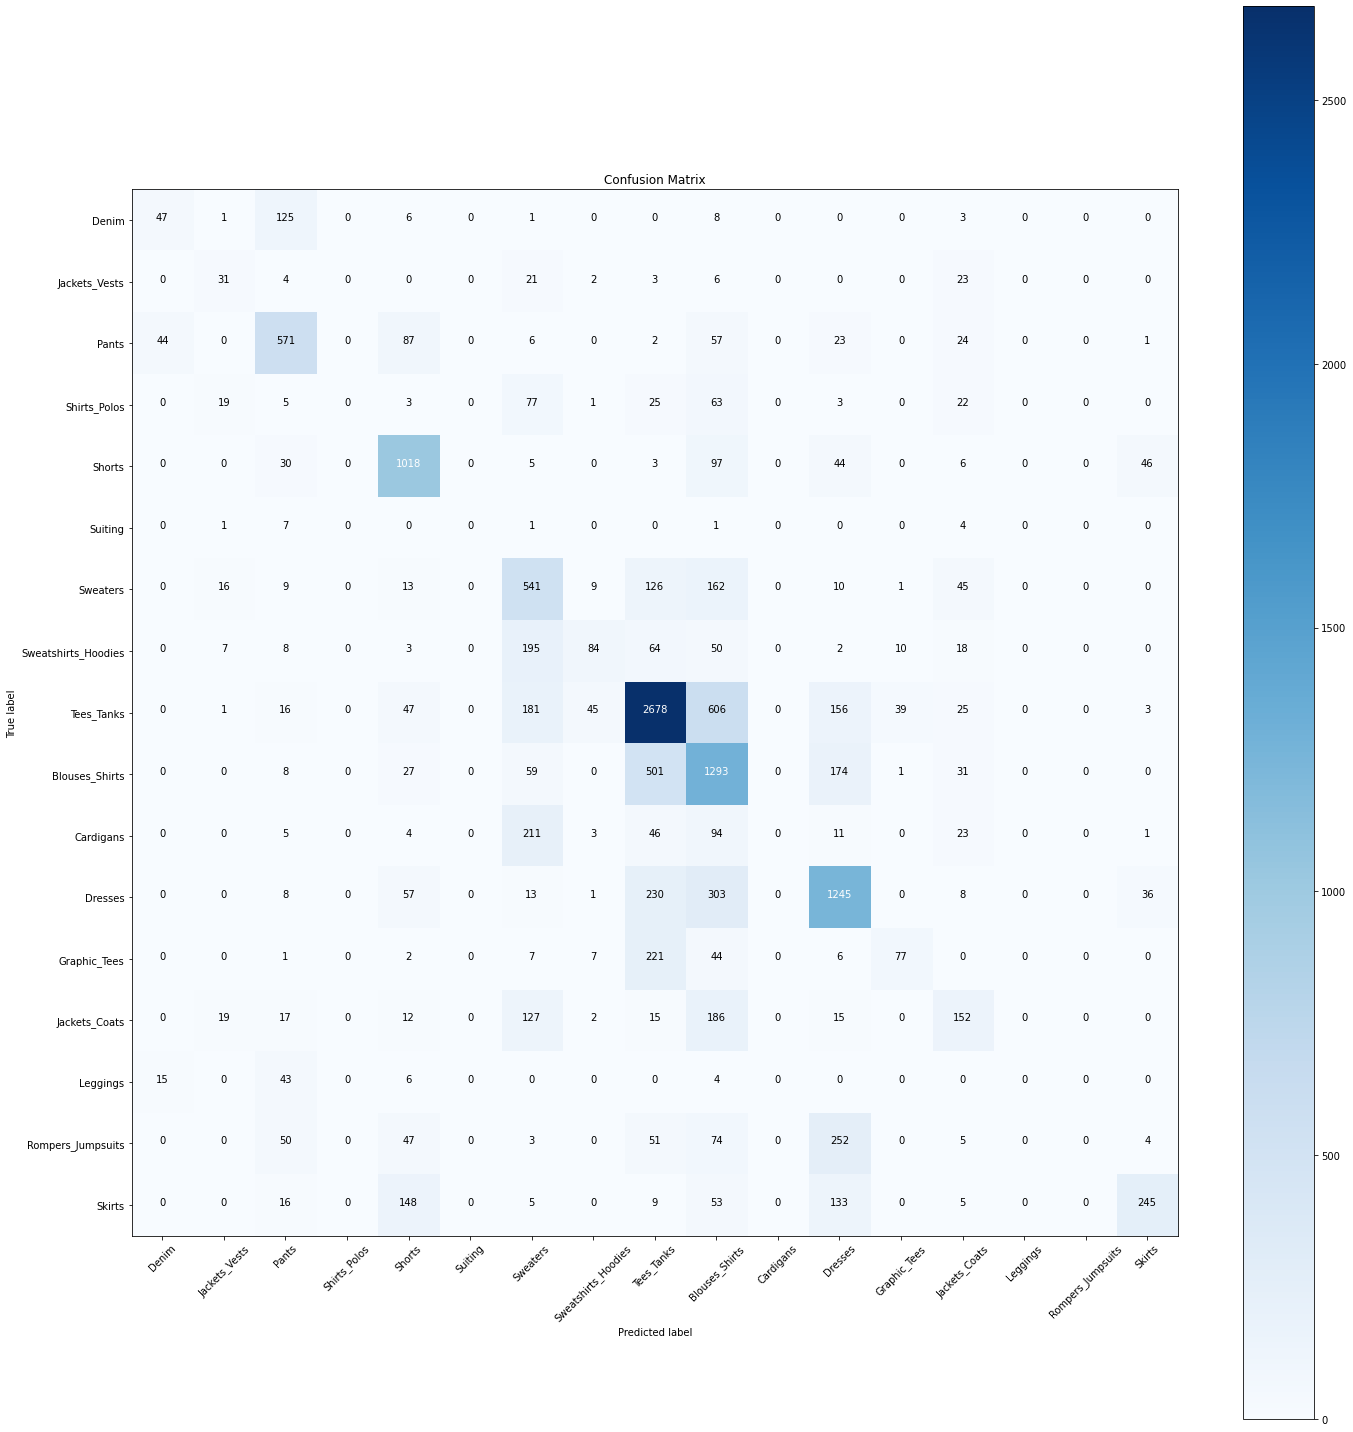

In [0]:
preds = get_all_preds(model=classification_model_2d,loader=query_dataloader)
cm = compute_confusion_matrix(torch.tensor(query_dataloader.dataset.class_ids).cuda(), preds)
plot_confusion_matrix(cm, class_mapping.keys())

Confusion matrix analysis appears to give similar information than in the previous analysis.

## Siamese Networks

### Siamese Networks with 2 dimensions with ResNet50 as output of embedding layer

In [0]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
cuda = torch.cuda.is_available()
from datasets import SiameseMMFashion

# This are the datasets that will be used to load the pairs. It is done by a composition of an extended class from SiameseMNIST
# that uses In_shop dataset from mmfashion project, and is an adapter from one interface to siamese_triplet interface to seamlessly work
# in the training loop.
siamese_train_dataset = SiameseMMFashion(train_dataset, train=True) # Returns pairs of images and target same/different
siamese_gallery_dataset = SiameseMMFashion(gallery_dataset, train=False) 
siamese_query_dataset = SiameseMMFashion(query_dataset, train=False)
batch_size = 64
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_gallery_loader = torch.utils.data.DataLoader(siamese_gallery_dataset, batch_size=batch_size, shuffle=False, **kwargs)
siamese_query_loader = torch.utils.data.DataLoader(siamese_query_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import MMFashionEmbeddingResNet50, SiameseNet
from losses import ContrastiveLoss

# This is the embedding net that will be shared by the two branches of the siamese network. 
# MMFashionEmbeddingNet is an extension of EmbeddingNet to be adapted to the new type of input data
embedding_net = MMFashionEmbeddingResNet50(out_dimensions=2)
# Step 3
model_siamese_2d = SiameseNet(embedding_net)
if cuda:
  model_siamese_2d.cuda()
    
# Step 4
margin = 5.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model_siamese_2d.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 20

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
path = os.path.join(models_path,'siamese_2d.model')
from trainer import fit
fit(siamese_train_loader, siamese_gallery_loader, model_siamese_2d, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
torch.save(model_siamese_2d.state_dict(), path)

Train: [0/25882 (0%)]	Loss: 5.925133
Train: [1280/25882 (5%)]	Loss: 4.137751
Train: [2560/25882 (10%)]	Loss: 3.700995
Train: [3840/25882 (15%)]	Loss: 3.409560
Train: [5120/25882 (20%)]	Loss: 3.382121
Train: [6400/25882 (25%)]	Loss: 3.259562
Train: [7680/25882 (30%)]	Loss: 3.538870
Train: [8960/25882 (35%)]	Loss: 3.168424
Train: [10240/25882 (40%)]	Loss: 3.289811
Train: [11520/25882 (44%)]	Loss: 3.039964
Train: [12800/25882 (49%)]	Loss: 3.231295
Train: [14080/25882 (54%)]	Loss: 2.942465
Train: [15360/25882 (59%)]	Loss: 3.144312
Train: [16640/25882 (64%)]	Loss: 3.113040
Train: [17920/25882 (69%)]	Loss: 2.885721
Train: [19200/25882 (74%)]	Loss: 3.095638
Train: [20480/25882 (79%)]	Loss: 3.037707
Train: [21760/25882 (84%)]	Loss: 3.064845
Train: [23040/25882 (89%)]	Loss: 3.049584
Train: [24320/25882 (94%)]	Loss: 2.960598
Train: [25600/25882 (99%)]	Loss: 2.991518
Epoch: 1/20. Train set: Average loss: 3.2250
Epoch: 1/20. Validation set: Average loss: 2.8839
Train: [0/25882 (0%)]	Loss: 2.807640

#### Plot embeddings

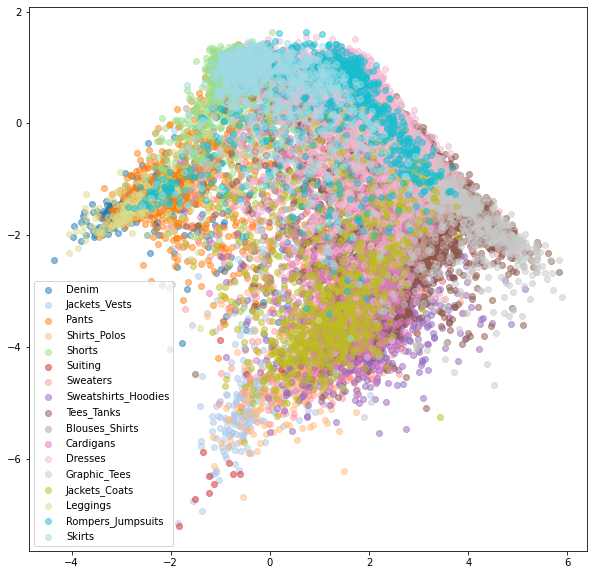

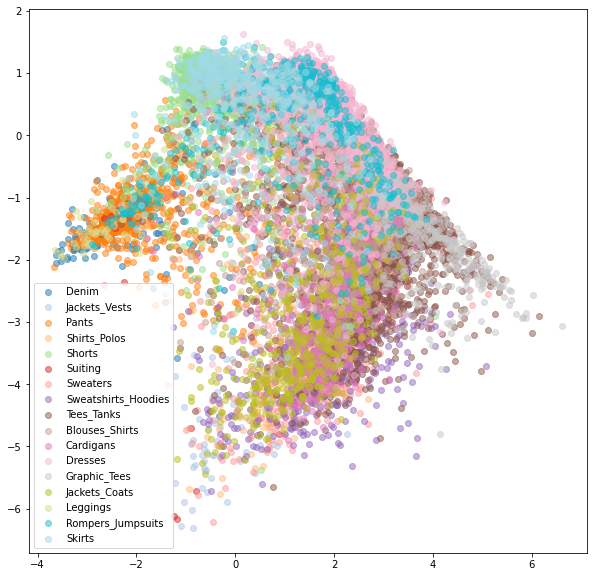

In [0]:
path = os.path.join(models_path,'siamese_2d.model')
embedding_net = MMFashionEmbeddingResNet50(out_dimensions=2)
model_siamese_2d = SiameseNet(embedding_net)
model_siamese_2d.load_state_dict(torch.load(path))
model_siamese_2d.eval()
if cuda:
  model_siamese_2d.cuda()
train_embeddings, train_labels = extract_embeddings(train_dataloader, model_siamese_2d)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(query_dataloader, model_siamese_2d)
plot_embeddings(val_embeddings, val_labels)

#### Train and evaluate kNN


In [0]:
train_embeddings, train_labels = extract_embeddings(train_dataloader, model_siamese_2d)
val_embeddings, val_labels = extract_embeddings(query_dataloader, model_siamese_2d)
print(fitAndEvaluateKNNAlgorithm(train_embeddings, train_labels, val_embeddings, val_labels))

0.47137431424954285


### Train a metric learning model with Siamese Networks with 2 dimensions as output of embedding layer and ResNet101 as architecture

In [0]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
cuda = torch.cuda.is_available()
from datasets import SiameseMMFashion

# This are the datasets that will be used to load the pairs. It is done by a composition of an extended class from SiameseMNIST
# that uses In_shop dataset from mmfashion project, and is an adapter from one interface to siamese_triplet interface to seamlessly work
# in the training loop.
siamese_train_dataset = SiameseMMFashion(train_dataset, train=True) # Returns pairs of images and target same/different
siamese_gallery_dataset = SiameseMMFashion(gallery_dataset, train=False) 
siamese_query_dataset = SiameseMMFashion(query_dataset, train=False)
batch_size = 64
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_gallery_loader = torch.utils.data.DataLoader(siamese_gallery_dataset, batch_size=batch_size, shuffle=False, **kwargs)
siamese_query_loader = torch.utils.data.DataLoader(siamese_query_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import MMFashionEmbeddingResNet101, SiameseNet
from losses import ContrastiveLoss

# This is the embedding net that will be shared by the two branches of the siamese network. 
# MMFashionEmbeddingNet is an extension of EmbeddingNet to be adapted to the new type of input data
embedding_net = MMFashionEmbeddingResNet101(out_dimensions=2)
# Step 3
model_siamese_2d_resnet101 = SiameseNet(embedding_net)
if cuda:
  model_siamese_2d_resnet101.cuda()
    
# Step 4
margin = 5.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model_siamese_2d_resnet101.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 20

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [0]:
path = os.path.join(models_path,'siamese_2d_resnet101.model')
from trainer import fit
fit(siamese_train_loader, siamese_gallery_loader, model_siamese_2d_resnet101, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
torch.save(model_siamese_2d_resnet101.state_dict(), path)

Train: [0/25882 (0%)]	Loss: 6.876604
Train: [1280/25882 (5%)]	Loss: 4.088462
Train: [2560/25882 (10%)]	Loss: 3.744748
Train: [3840/25882 (15%)]	Loss: 3.420845
Train: [5120/25882 (20%)]	Loss: 3.440077
Train: [6400/25882 (25%)]	Loss: 3.128571
Train: [7680/25882 (30%)]	Loss: 3.244731
Train: [8960/25882 (35%)]	Loss: 3.102227
Train: [10240/25882 (40%)]	Loss: 3.115355
Train: [11520/25882 (44%)]	Loss: 3.070477
Train: [12800/25882 (49%)]	Loss: 3.130478
Train: [14080/25882 (54%)]	Loss: 3.117460
Train: [15360/25882 (59%)]	Loss: 2.943745
Train: [16640/25882 (64%)]	Loss: 2.965734
Train: [17920/25882 (69%)]	Loss: 2.972780
Train: [19200/25882 (74%)]	Loss: 2.937774
Train: [20480/25882 (79%)]	Loss: 2.811099
Train: [21760/25882 (84%)]	Loss: 2.845252
Train: [23040/25882 (89%)]	Loss: 2.734956
Train: [24320/25882 (94%)]	Loss: 2.795509
Train: [25600/25882 (99%)]	Loss: 2.801631
Epoch: 1/20. Train set: Average loss: 3.1283
Epoch: 1/20. Validation set: Average loss: 2.7833
Train: [0/25882 (0%)]	Loss: 2.467637

#### Plot embeddings

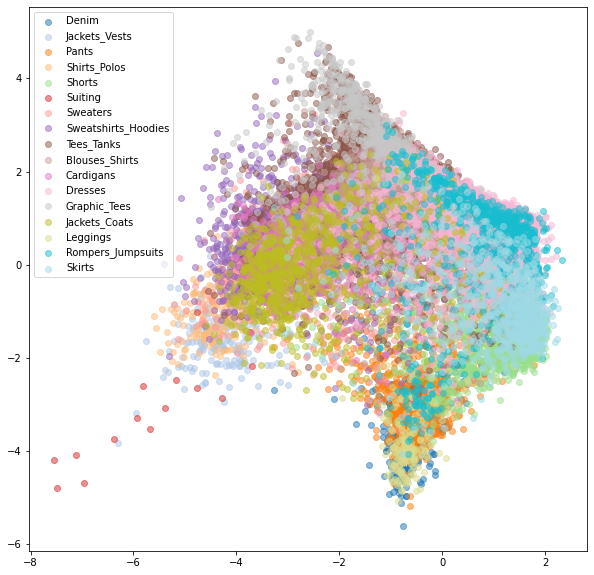

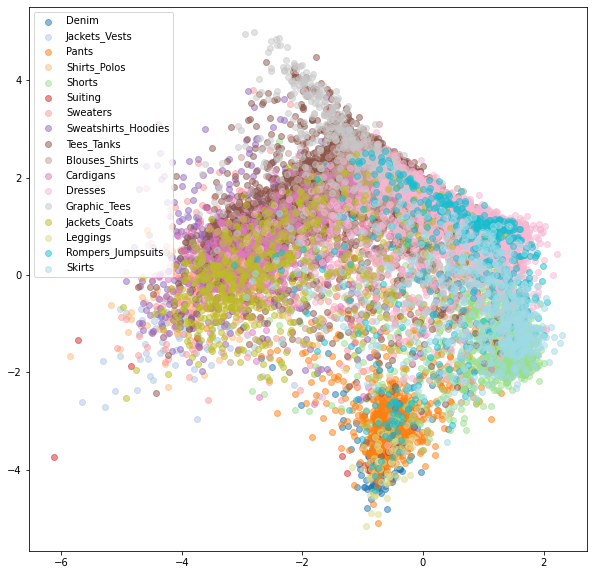

In [0]:
path = os.path.join(models_path,'siamese_2d_resnet101.model')
embedding_net = MMFashionEmbeddingResNet101(out_dimensions=2)
model_siamese_2d_resnet101 = SiameseNet(embedding_net)
model_siamese_2d_resnet101.load_state_dict(torch.load(path))
model_siamese_2d_resnet101.eval()
if cuda:
  model_siamese_2d_resnet101.cuda()
train_embeddings, train_labels = extract_embeddings(train_dataloader, model_siamese_2d_resnet101)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(query_dataloader, model_siamese_2d_resnet101)
plot_embeddings(val_embeddings, val_labels)

#### Train and evaluate kNN

In [0]:
train_embeddings, train_labels = extract_embeddings(train_dataloader, model_siamese_2d_resnet101)
val_embeddings, val_labels = extract_embeddings(query_dataloader, model_siamese_2d_resnet101)
print(fitAndEvaluateKNNAlgorithm(train_embeddings, train_labels, val_embeddings, val_labels))

0.48283865522577013


### Train a metric learning model with Siamese Networks with 32 dimensions as output of embedding layer.



In [0]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
cuda = torch.cuda.is_available()
from datasets import SiameseMMFashion

# This are the datasets that will be used to load the pairs. It is done by a composition of an extended class from SiameseMNIST
# that uses In_shop dataset from mmfashion project, and is an adapter from one interface to siamese_triplet interface to seamlessly work
# in the training loop.
siamese_train_dataset = SiameseMMFashion(train_dataset, train=True) # Returns pairs of images and target same/different
siamese_gallery_dataset = SiameseMMFashion(gallery_dataset, train=False) 
siamese_query_dataset = SiameseMMFashion(query_dataset, train=False)
batch_size = 64
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_gallery_loader = torch.utils.data.DataLoader(siamese_gallery_dataset, batch_size=batch_size, shuffle=False, **kwargs)
siamese_query_loader = torch.utils.data.DataLoader(siamese_query_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import MMFashionEmbeddingResNet101, SiameseNet
from losses import ContrastiveLoss

# This is the embedding net that will be shared by the two branches of the siamese network. 
# MMFashionEmbeddingNet is an extension of EmbeddingNet to be adapted to the new type of input data
embedding_net = MMFashionEmbeddingResNet101(out_dimensions=32)
# Step 3
model_siamese_32d_resnet101 = SiameseNet(embedding_net)
if cuda:
  model_siamese_32d_resnet101.cuda()
    
# Step 4
margin = 5.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model_siamese_32d_resnet101.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 20

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [0]:
path = os.path.join(models_path,'siamese_32d_resnet101.model')
from trainer import fit
fit(siamese_train_loader, siamese_gallery_loader, model_siamese_32d_resnet101, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
torch.save(model_siamese_32d_resnet101.state_dict(), path)

Train: [0/25882 (0%)]	Loss: 6.020946
Train: [1280/25882 (5%)]	Loss: 3.521274
Train: [2560/25882 (10%)]	Loss: 3.372294
Train: [3840/25882 (15%)]	Loss: 3.176699
Train: [5120/25882 (20%)]	Loss: 3.121424
Train: [6400/25882 (25%)]	Loss: 3.077112
Train: [7680/25882 (30%)]	Loss: 3.027401
Train: [8960/25882 (35%)]	Loss: 3.120054
Train: [10240/25882 (40%)]	Loss: 2.979333
Train: [11520/25882 (44%)]	Loss: 3.046958
Train: [12800/25882 (49%)]	Loss: 2.909867
Train: [14080/25882 (54%)]	Loss: 2.957442
Train: [15360/25882 (59%)]	Loss: 2.860234
Train: [16640/25882 (64%)]	Loss: 2.858780
Train: [17920/25882 (69%)]	Loss: 2.725773
Train: [19200/25882 (74%)]	Loss: 2.763025
Train: [20480/25882 (79%)]	Loss: 2.621900
Train: [21760/25882 (84%)]	Loss: 2.739108
Train: [23040/25882 (89%)]	Loss: 2.615216
Train: [24320/25882 (94%)]	Loss: 2.695385
Train: [25600/25882 (99%)]	Loss: 2.595992
Epoch: 1/20. Train set: Average loss: 2.9442
Epoch: 1/20. Validation set: Average loss: 2.6955
Train: [0/25882 (0%)]	Loss: 1.909928

#### Plot embeddings with t-SNE projection

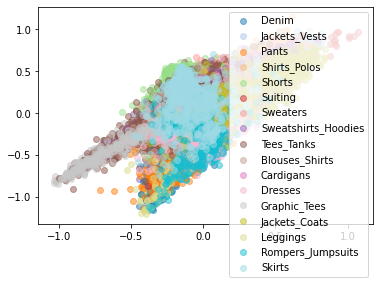

In [0]:
path = os.path.join(models_path,'siamese_32d_resnet101.model')
embedding_net = MMFashionEmbeddingResNet101(out_dimensions=32)
model_siamese_32d_resnet101 = SiameseNet(embedding_net)
model_siamese_32d_resnet101.load_state_dict(torch.load(path))
model_siamese_32d_resnet101.eval()
if cuda:
  model_siamese_32d_resnet101.cuda()
train_embeddings, train_labels = extract_embeddings(train_dataloader, model_siamese_32d_resnet101)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(query_dataloader, model_siamese_32d_resnet101)
plot_embeddings(val_embeddings, val_labels)

#### Plot embeddings with PCA projection


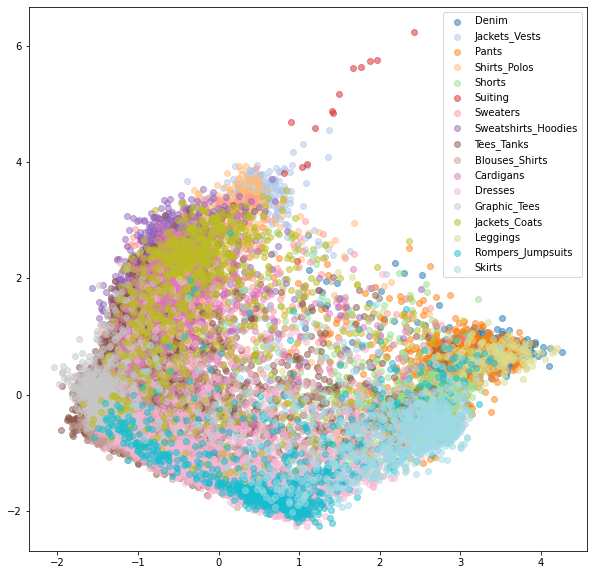

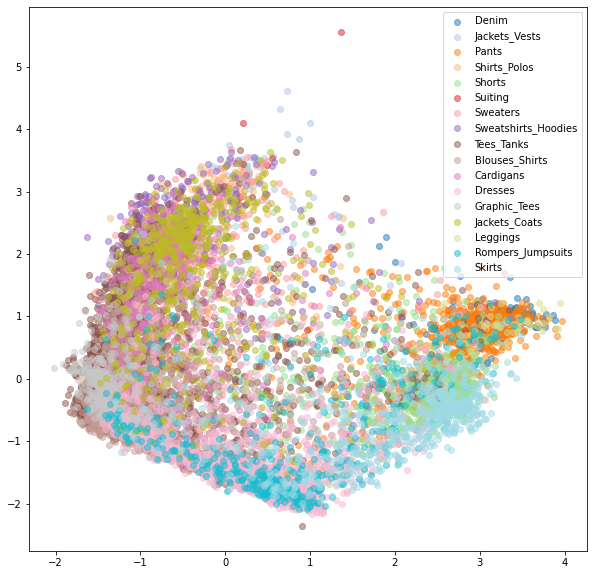

In [0]:
path = os.path.join(models_path,'siamese_32d_resnet101.model')
embedding_net = MMFashionEmbeddingResNet101(out_dimensions=32)
model_siamese_32d_resnet101 = SiameseNet(embedding_net)
model_siamese_32d_resnet101.load_state_dict(torch.load(path))
model_siamese_32d_resnet101.eval()
if cuda:
  model_siamese_32d_resnet101.cuda()
train_embeddings, train_labels = extract_embeddings(train_dataloader, model_siamese_32d_resnet101)
plot_embeddings(train_embeddings, train_labels, transform='PCA')
val_embeddings, val_labels = extract_embeddings(query_dataloader, model_siamese_32d_resnet101)
plot_embeddings(val_embeddings, val_labels, transform='PCA')

#### Train and evaluate kNN

In [0]:
train_embeddings, train_labels = extract_embeddings(train_dataloader, model_siamese_32d_resnet101)
val_embeddings, val_labels = extract_embeddings(query_dataloader, model_siamese_32d_resnet101)
print(fitAndEvaluateKNNAlgorithm(train_embeddings, train_labels, val_embeddings, val_labels))

0.5640737093824729


## Triplet Networks

### Train a metric learning model with Triplet Networks with 2 dimensions as output of embedding layer

In [0]:
# Set up data loaders
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
from datasets import TripletMMFashion

triplet_train_dataset = TripletMMFashion(train_dataset, train=True) # Returns pairs of images and target same/different
triplet_gallery_dataset = TripletMMFashion(gallery_dataset, train=False) 
triplet_query_dataset = TripletMMFashion(query_dataset, train=False)
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_gallery_loader = torch.utils.data.DataLoader(triplet_gallery_dataset, batch_size=batch_size, shuffle=False, **kwargs)
triplet_query_loader = torch.utils.data.DataLoader(triplet_query_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import MMFashionEmbeddingResNet101, TripletNet
from losses import TripletLoss

margin = 5.
embedding_net = MMFashionEmbeddingResNet101(out_dimensions=2)
model_triplet_2d = TripletNet(embedding_net)
if cuda:
  model_triplet_2d.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model_triplet_2d.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 20

In [0]:
path = os.path.join(models_path,'triplet_2d.model')
from trainer import fit
fit(triplet_train_loader, triplet_gallery_loader, model_triplet_2d, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
torch.save(model_triplet_2d.state_dict(), path)

Train: [0/25882 (0%)]	Loss: 5.000062
Train: [1280/25882 (5%)]	Loss: 4.960775
Train: [2560/25882 (10%)]	Loss: 4.971580
Train: [3840/25882 (15%)]	Loss: 4.476423
Train: [5120/25882 (20%)]	Loss: 4.398044
Train: [6400/25882 (25%)]	Loss: 4.142479
Train: [7680/25882 (30%)]	Loss: 4.155698
Train: [8960/25882 (35%)]	Loss: 4.105094
Train: [10240/25882 (40%)]	Loss: 3.344053
Train: [11520/25882 (44%)]	Loss: 3.378254
Train: [12800/25882 (49%)]	Loss: 2.720776
Train: [14080/25882 (54%)]	Loss: 2.967488
Train: [15360/25882 (59%)]	Loss: 1.768167
Train: [16640/25882 (64%)]	Loss: 0.897919
Train: [17920/25882 (69%)]	Loss: 1.141036
Train: [19200/25882 (74%)]	Loss: 1.824687
Train: [20480/25882 (79%)]	Loss: 0.491976
Train: [21760/25882 (84%)]	Loss: 0.297637
Train: [23040/25882 (89%)]	Loss: 0.024434
Train: [24320/25882 (94%)]	Loss: 2.433912
Train: [25600/25882 (99%)]	Loss: 2.917231
Epoch: 1/20. Train set: Average loss: 2.7667
Epoch: 1/20. Validation set: Average loss: 4.2392
Train: [0/25882 (0%)]	Loss: 2.559462

#### Plot embeddings

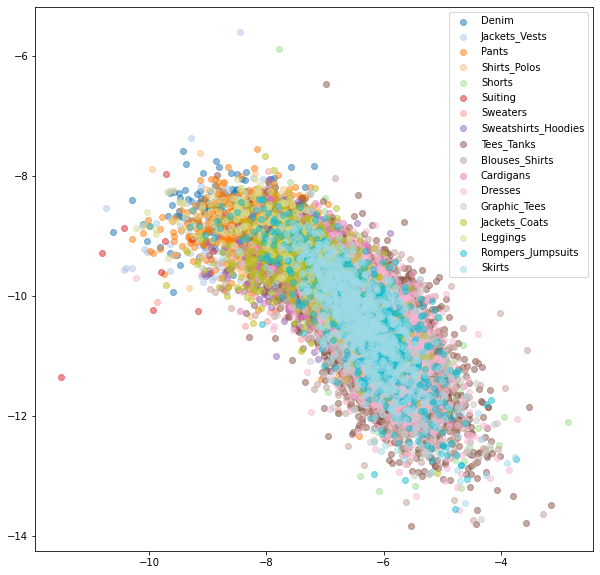

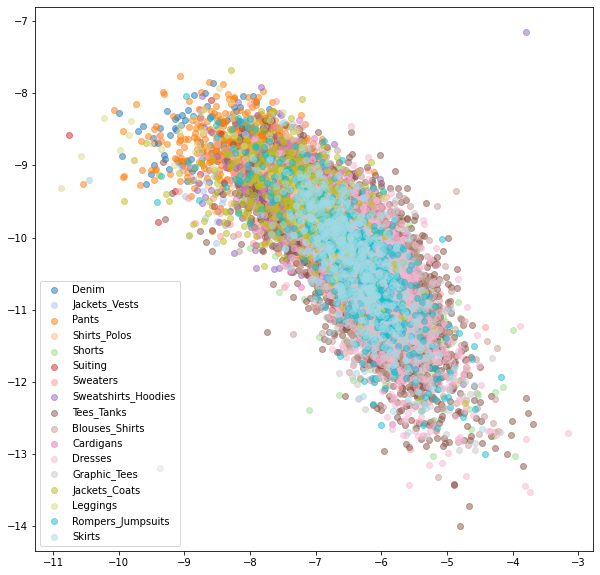

In [0]:
path = os.path.join(models_path,'triplet_2d.model')
embedding_net = MMFashionEmbeddingResNet101(out_dimensions=2)
model_triplet_2d = TripletNet(embedding_net)
model_triplet_2d.load_state_dict(torch.load(path))
model_triplet_2d.eval()
if cuda:
  model_triplet_2d.cuda()
train_embeddings, train_labels = extract_embeddings(train_dataloader, model_triplet_2d)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(query_dataloader, model_triplet_2d)
plot_embeddings(val_embeddings, val_labels)

#### Train and evaluate kNN


In [0]:
train_embeddings, train_labels = extract_embeddings(train_dataloader, model_triplet_2d)
val_embeddings, val_labels = extract_embeddings(query_dataloader, model_triplet_2d)
print(fitAndEvaluateKNNAlgorithm(train_embeddings, train_labels, val_embeddings, val_labels))

0.28449852299901535


### Train a metric learning model with Triplet Networks with 32 dimensions as output of embedding layer


In [6]:
# Set up data loaders
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
cuda = torch.cuda.is_available()

import numpy as np
from datasets import TripletMMFashion

triplet_train_dataset = TripletMMFashion(train_dataset, train=True) # Returns pairs of images and target same/different
triplet_gallery_dataset = TripletMMFashion(gallery_dataset, train=False) 
triplet_query_dataset = TripletMMFashion(query_dataset, train=False)
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_gallery_loader = torch.utils.data.DataLoader(triplet_gallery_dataset, batch_size=batch_size, shuffle=False, **kwargs)
triplet_query_loader = torch.utils.data.DataLoader(triplet_query_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import MMFashionEmbeddingResNet101, TripletNet
from losses import TripletLoss

margin = 5.
embedding_net = MMFashionEmbeddingResNet101(out_dimensions=32)
model_triplet_32d = TripletNet(embedding_net)
if cuda:
  model_triplet_32d.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model_triplet_32d.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 20

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [7]:
path = os.path.join(models_path,'triplet_32d.model')
from trainer import fit
fit(triplet_train_loader, triplet_gallery_loader, model_triplet_32d, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
torch.save(model_triplet_32d.state_dict(), path)

Train: [0/25882 (0%)]	Loss: 4.996966
Train: [1280/25882 (5%)]	Loss: 4.637612
Train: [2560/25882 (10%)]	Loss: 4.393938
Train: [3840/25882 (15%)]	Loss: 4.162726
Train: [5120/25882 (20%)]	Loss: 3.774466
Train: [6400/25882 (25%)]	Loss: 3.483006
Train: [7680/25882 (30%)]	Loss: 2.866969
Train: [8960/25882 (35%)]	Loss: 2.164021
Train: [10240/25882 (40%)]	Loss: 1.013098
Train: [11520/25882 (44%)]	Loss: 0.720762
Train: [12800/25882 (49%)]	Loss: 2.020085
Train: [14080/25882 (54%)]	Loss: 1.679217
Train: [15360/25882 (59%)]	Loss: 0.305135
Train: [16640/25882 (64%)]	Loss: 0.357937
Train: [17920/25882 (69%)]	Loss: 0.057166
Train: [19200/25882 (74%)]	Loss: 1.916824
Train: [20480/25882 (79%)]	Loss: 1.937636
Train: [21760/25882 (84%)]	Loss: 0.459979
Train: [23040/25882 (89%)]	Loss: 0.304418
Train: [24320/25882 (94%)]	Loss: 0.444218
Train: [25600/25882 (99%)]	Loss: 0.797145
Epoch: 1/20. Train set: Average loss: 1.9290
Epoch: 1/20. Validation set: Average loss: 4.1996
Train: [0/25882 (0%)]	Loss: 0.166060

#### Plot embeddings

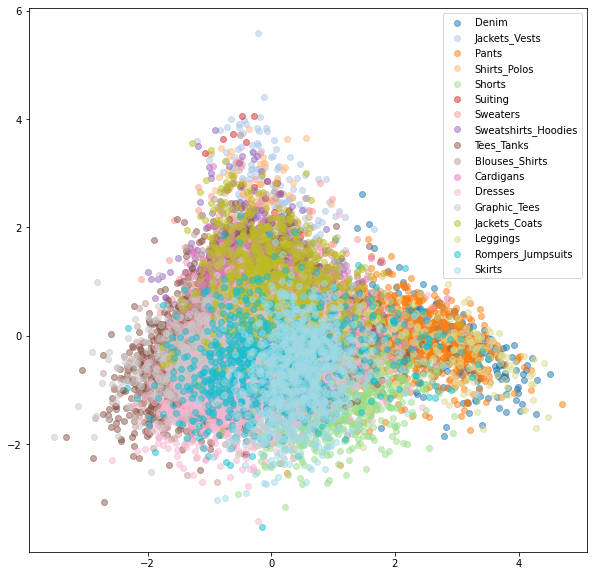

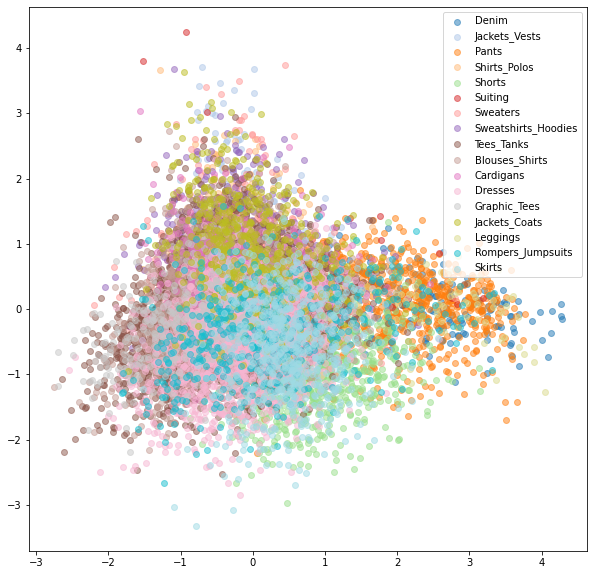

In [10]:
path = os.path.join(models_path,'triplet_32d.model')
embedding_net = MMFashionEmbeddingResNet101(out_dimensions=32)
model_triplet_32d = TripletNet(embedding_net)
model_triplet_32d.load_state_dict(torch.load(path))
model_triplet_32d.eval()
if cuda:
  model_triplet_32d.cuda()
train_embeddings, train_labels = extract_embeddings(train_dataloader, model_triplet_32d)
plot_embeddings(train_embeddings, train_labels, transform="PCA")
val_embeddings, val_labels = extract_embeddings(query_dataloader, model_triplet_32d)
plot_embeddings(val_embeddings, val_labels, transform="PCA")

#### Train and evaluate kNN

In [11]:
train_embeddings, train_labels = extract_embeddings(train_dataloader, model_triplet_32d)
val_embeddings, val_labels = extract_embeddings(query_dataloader, model_triplet_32d)
print(fitAndEvaluateKNNAlgorithm(train_embeddings, train_labels, val_embeddings, val_labels))

0.3541285694190463


## Negative Mining with Siamese Networks


## Train a metric learning model with Siamese network with 2 dimensions as embedding and negative mining

In [0]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(torch.tensor(train_dataset.class_ids), n_classes=n_classes, n_samples=25)
gallery_batch_sampler = BalancedBatchSampler(torch.tensor(gallery_dataset.class_ids), n_classes=n_classes, n_samples=25)
query_batch_sampler = BalancedBatchSampler(torch.tensor(query_dataset.class_ids), n_classes=n_classes, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_gallery_loader = torch.utils.data.DataLoader(gallery_dataset, batch_sampler=gallery_batch_sampler, **kwargs)
online_query_loader = torch.utils.data.DataLoader(query_dataset, batch_sampler=query_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import MMFashionEmbeddingResNet101
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 5.
embedding_net = MMFashionEmbeddingResNet101(out_dimensions=2)
model_online_siamese_2d = embedding_net
if cuda:
  model_online_siamese_2d.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model_online_siamese_2d.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 20

In [0]:
path = os.path.join(models_path, 'model_online_siamese_resnet101_2d.model')
from trainer import fit
fit(online_train_loader, online_gallery_loader, model_online_siamese_2d, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
torch.save(model_online_siamese_2d.state_dict(), path)

Train: [0/25882 (0%)]	Loss: 12.447559
Train: [8300/25882 (33%)]	Loss: 11.921935
Train: [16600/25882 (67%)]	Loss: 11.539504
Epoch: 1/20. Train set: Average loss: 11.6259
Epoch: 1/20. Validation set: Average loss: 11.6009
Train: [0/25882 (0%)]	Loss: 11.162493
Train: [8300/25882 (33%)]	Loss: 11.252574
Train: [16600/25882 (67%)]	Loss: 11.125213
Epoch: 2/20. Train set: Average loss: 11.1574
Epoch: 2/20. Validation set: Average loss: 11.4705
Train: [0/25882 (0%)]	Loss: 11.025558
Train: [8300/25882 (33%)]	Loss: 10.965927
Train: [16600/25882 (67%)]	Loss: 10.900425
Epoch: 3/20. Train set: Average loss: 10.9188
Epoch: 3/20. Validation set: Average loss: 11.4564
Train: [0/25882 (0%)]	Loss: 11.008829
Train: [8300/25882 (33%)]	Loss: 10.814906
Train: [16600/25882 (67%)]	Loss: 10.741249
Epoch: 4/20. Train set: Average loss: 10.7609
Epoch: 4/20. Validation set: Average loss: 11.3276
Train: [0/25882 (0%)]	Loss: 10.735474
Train: [8300/25882 (33%)]	Loss: 10.715554
Train: [16600/25882 (67%)]	Loss: 10.6092

#### Plot embeddings

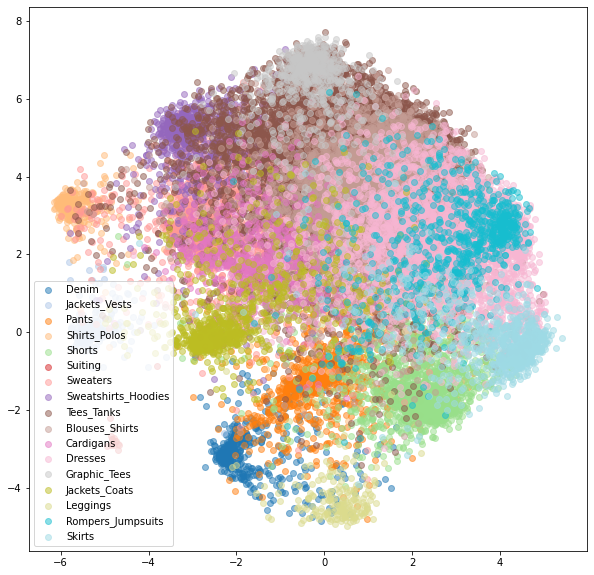

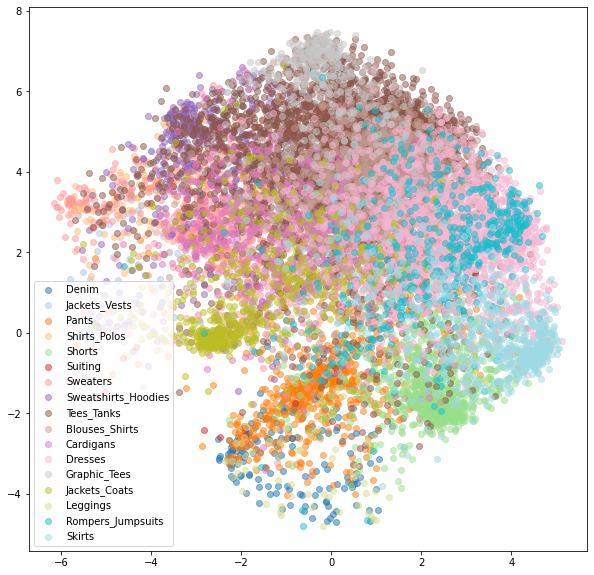

In [0]:
def extract_embeddings(dataloader, model):
  with torch.no_grad():
    model.eval()
    embeddings = np.zeros((len(dataloader.dataset), model.out_dimensions))
    labels = np.zeros(len(dataloader.dataset))
    k = 0
    for loader in dataloader:
      images = loader['img']
      target = loader['target']
      if cuda:
        images = images.cuda()
      embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
      labels[k:k+len(images)] = target.numpy()
      k += len(images)
    return embeddings, labels

path = os.path.join(models_path,'model_online_siamese_resnet101_2d.model')
embedding_net = MMFashionEmbeddingResNet101(out_dimensions=2)
model_online_siamese_2d = embedding_net
model_online_siamese_2d.load_state_dict(torch.load(path))
model_online_siamese_2d.eval()
if cuda:
    model_online_siamese_2d.cuda()
train_embeddings, train_labels = extract_embeddings(train_dataloader, model_online_siamese_2d)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(query_dataloader, model_online_siamese_2d)
plot_embeddings(val_embeddings, val_labels)

#### Train and evaluate KNN


In [0]:
train_embeddings, train_labels = extract_embeddings(train_dataloader, model_online_siamese_2d)
val_embeddings, val_labels = extract_embeddings(query_dataloader, model_online_siamese_2d)
print(fitAndEvaluateKNNAlgorithm(train_embeddings, train_labels, val_embeddings, val_labels))

0.5238430158953439


## Train a metric learning model with Siamese network with 32 dimensions as embedding and negative mining

In [0]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(torch.tensor(train_dataset.class_ids), n_classes=n_classes, n_samples=25)
gallery_batch_sampler = BalancedBatchSampler(torch.tensor(gallery_dataset.class_ids), n_classes=n_classes, n_samples=25)
query_batch_sampler = BalancedBatchSampler(torch.tensor(query_dataset.class_ids), n_classes=n_classes, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_gallery_loader = torch.utils.data.DataLoader(gallery_dataset, batch_sampler=gallery_batch_sampler, **kwargs)
online_query_loader = torch.utils.data.DataLoader(query_dataset, batch_sampler=query_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import MMFashionEmbeddingResNet101
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 5.
embedding_net = MMFashionEmbeddingResNet101(out_dimensions=32)
model_online_siamese_32d = embedding_net
if cuda:
  model_online_siamese_32d.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model_online_siamese_32d.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 20

In [0]:
path = os.path.join(models_path, 'model_online_siamese_resnet101_32d.model')
from trainer import fit
fit(online_train_loader, online_gallery_loader, model_online_siamese_32d, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
torch.save(model_online_siamese_32d.state_dict(), path)

Train: [0/25882 (0%)]	Loss: 11.722705
Train: [8300/25882 (33%)]	Loss: 8.437716
Train: [16600/25882 (67%)]	Loss: 7.609421
Epoch: 1/20. Train set: Average loss: 7.8633
Epoch: 1/20. Validation set: Average loss: 7.6645
Train: [0/25882 (0%)]	Loss: 7.099365
Train: [8300/25882 (33%)]	Loss: 7.175657
Train: [16600/25882 (67%)]	Loss: 7.090127
Epoch: 2/20. Train set: Average loss: 7.0923
Epoch: 2/20. Validation set: Average loss: 7.6673
Train: [0/25882 (0%)]	Loss: 6.924505
Train: [8300/25882 (33%)]	Loss: 6.878577
Train: [16600/25882 (67%)]	Loss: 6.789074
Epoch: 3/20. Train set: Average loss: 6.8271
Epoch: 3/20. Validation set: Average loss: 7.5286
Train: [0/25882 (0%)]	Loss: 6.694234
Train: [8300/25882 (33%)]	Loss: 6.708765
Train: [16600/25882 (67%)]	Loss: 6.646926
Epoch: 4/20. Train set: Average loss: 6.6411
Epoch: 4/20. Validation set: Average loss: 7.6863
Train: [0/25882 (0%)]	Loss: 6.668417
Train: [8300/25882 (33%)]	Loss: 6.501991
Train: [16600/25882 (67%)]	Loss: 6.478513
Epoch: 5/20. Train 

### Plot embeddings with PCA

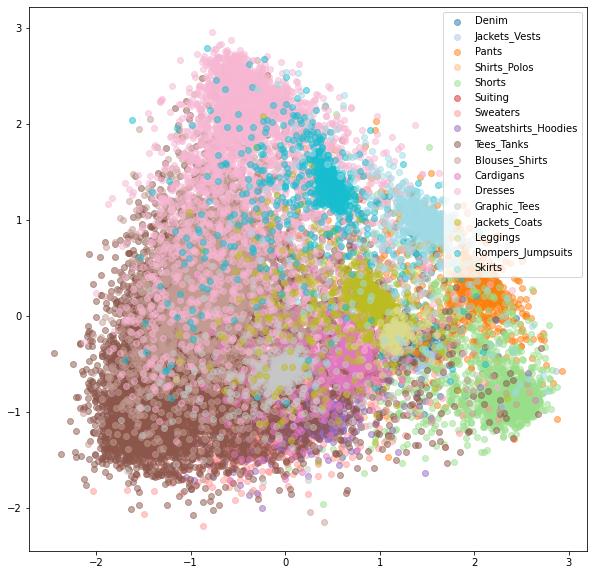

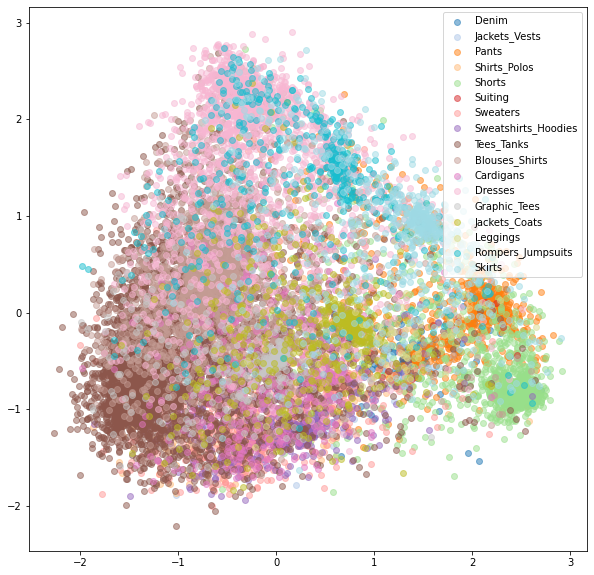

In [0]:
def extract_embeddings(dataloader, model):
  with torch.no_grad():
    model.eval()
    embeddings = np.zeros((len(dataloader.dataset), model.out_dimensions))
    labels = np.zeros(len(dataloader.dataset))
    k = 0
    for loader in dataloader:
      images = loader['img']
      target = loader['target']
      if cuda:
        images = images.cuda()
      embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
      labels[k:k+len(images)] = target.numpy()
      k += len(images)
    return embeddings, labels

path = os.path.join(models_path,'model_online_siamese_resnet101_32d.model')
embedding_net = MMFashionEmbeddingResNet101(out_dimensions=32)
model_online_siamese_32d = embedding_net
model_online_siamese_32d.load_state_dict(torch.load(path))
model_online_siamese_32d.eval()
if cuda:
    model_online_siamese_32d.cuda()
train_embeddings, train_labels = extract_embeddings(train_dataloader, model_online_siamese_32d)
plot_embeddings(train_embeddings, train_labels, transform="PCA")
val_embeddings, val_labels = extract_embeddings(query_dataloader, model_online_siamese_32d)
plot_embeddings(val_embeddings, val_labels, transform="PCA")

### Train and evaluate KNN

In [0]:
train_embeddings, train_labels = extract_embeddings(train_dataloader, model_online_siamese_32d)
val_embeddings, val_labels = extract_embeddings(query_dataloader, model_online_siamese_32d)
print(fitAndEvaluateKNNAlgorithm(train_embeddings, train_labels, val_embeddings, val_labels))

0.6185820790547194


## Negative mining with Triplet Networks


### Train a metric learning model with Triplet network with 2 dimensions as embedding and negative mining

In [0]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(torch.tensor(train_dataset.class_ids), n_classes=n_classes, n_samples=25)
gallery_batch_sampler = BalancedBatchSampler(torch.tensor(gallery_dataset.class_ids), n_classes=n_classes, n_samples=25)
query_batch_sampler = BalancedBatchSampler(torch.tensor(query_dataset.class_ids), n_classes=n_classes, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_gallery_loader = torch.utils.data.DataLoader(gallery_dataset, batch_sampler=gallery_batch_sampler, **kwargs)
online_query_loader = torch.utils.data.DataLoader(query_dataset, batch_sampler=query_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import MMFashionEmbeddingResNet101
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 5.
embedding_net = MMFashionEmbeddingResNet101(out_dimensions=2)
model_online_triplet_2d = embedding_net
if cuda:
    model_online_triplet_2d.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model_online_triplet_2d.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 20

In [0]:
path = os.path.join(models_path, 'model_online_triplet_2d.model')
from trainer import fit
fit(online_train_loader, online_gallery_loader, model_online_triplet_2d, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])
torch.save(model_online_triplet_2d.state_dict(), path)

Train: [0/25882 (0%)]	Loss: 4.999598	Average nonzero triplets: 4905.0
Train: [8300/25882 (33%)]	Loss: 5.144205	Average nonzero triplets: 4905.0
Train: [16600/25882 (67%)]	Loss: 5.060521	Average nonzero triplets: 4905.0
Epoch: 1/20. Train set: Average loss: 5.0702	Average nonzero triplets: 4901.616666666667
Epoch: 1/20. Validation set: Average loss: 5.8327	Average nonzero triplets: 4844.6551724137935
Train: [0/25882 (0%)]	Loss: 5.539492	Average nonzero triplets: 4893.0
Train: [8300/25882 (33%)]	Loss: 5.037438	Average nonzero triplets: 4863.666666666667
Train: [16600/25882 (67%)]	Loss: 5.030528	Average nonzero triplets: 4862.878048780488
Epoch: 2/20. Train set: Average loss: 5.0409	Average nonzero triplets: 4857.6
Epoch: 2/20. Validation set: Average loss: 5.4160	Average nonzero triplets: 4843.896551724138
Train: [0/25882 (0%)]	Loss: 4.800343	Average nonzero triplets: 4816.0
Train: [8300/25882 (33%)]	Loss: 5.030510	Average nonzero triplets: 4845.047619047619
Train: [16600/25882 (67%)]	Lo

#### Plot embeddings


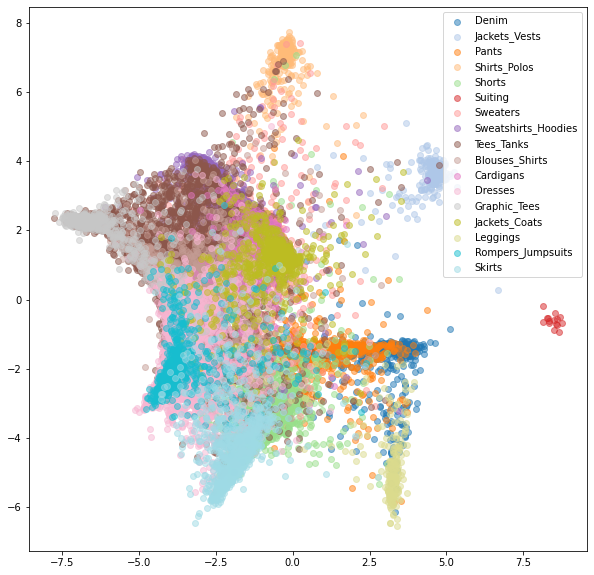

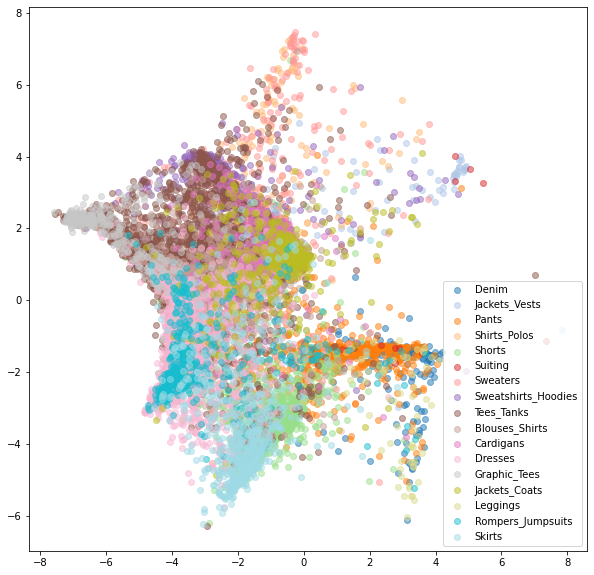

In [0]:
path = os.path.join(models_path,'model_online_triplet_2d.model')
embedding_net = MMFashionEmbeddingResNet101(out_dimensions=2)
model_online_triplet_2d = embedding_net
model_online_triplet_2d.load_state_dict(torch.load(path))
model_online_triplet_2d.eval()
if cuda:
    model_online_triplet_2d.cuda()
train_embeddings, train_labels = extract_embeddings(train_dataloader, model_online_triplet_2d)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(query_dataloader, model_online_triplet_2d)
plot_embeddings(val_embeddings, val_labels)

#### Train and evaluate KNN

In [0]:
train_embeddings, train_labels = extract_embeddings(train_dataloader, model_online_triplet_2d)
val_embeddings, val_labels = extract_embeddings(query_dataloader, model_online_triplet_2d)
print(fitAndEvaluateKNNAlgorithm(train_embeddings, train_labels, val_embeddings, val_labels))

0.5064706709804473


### Train a metric learning model with Triplet network with 32 dimensions as embedding and negative mining

In [0]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(torch.tensor(train_dataset.class_ids), n_classes=n_classes, n_samples=25)
gallery_batch_sampler = BalancedBatchSampler(torch.tensor(gallery_dataset.class_ids), n_classes=n_classes, n_samples=25)
query_batch_sampler = BalancedBatchSampler(torch.tensor(query_dataset.class_ids), n_classes=n_classes, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_gallery_loader = torch.utils.data.DataLoader(gallery_dataset, batch_sampler=gallery_batch_sampler, **kwargs)
online_query_loader = torch.utils.data.DataLoader(query_dataset, batch_sampler=query_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import MMFashionEmbeddingResNet101
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 5.
embedding_net = MMFashionEmbeddingResNet101(out_dimensions=32)
model_online_triplet_32d = embedding_net
if cuda:
    model_online_triplet_32d.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model_online_triplet_32d.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 20

In [0]:
path = os.path.join(models_path, 'model_online_triplet_32d.model')
from trainer import fit
fit(online_train_loader, online_gallery_loader, model_online_triplet_32d, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])
torch.save(model_online_triplet_32d.state_dict(), path)

Train: [0/25882 (0%)]	Loss: 4.997577	Average nonzero triplets: 4905.0
Train: [8300/25882 (33%)]	Loss: 5.295288	Average nonzero triplets: 4904.9047619047615
Train: [16600/25882 (67%)]	Loss: 5.036304	Average nonzero triplets: 4904.634146341464
Epoch: 1/20. Train set: Average loss: 5.1342	Average nonzero triplets: 4900.583333333333
Epoch: 1/20. Validation set: Average loss: 5.8011	Average nonzero triplets: 4844.413793103448
Train: [0/25882 (0%)]	Loss: 4.714947	Average nonzero triplets: 4841.0
Train: [8300/25882 (33%)]	Loss: 5.058084	Average nonzero triplets: 4867.190476190476
Train: [16600/25882 (67%)]	Loss: 4.966556	Average nonzero triplets: 4856.341463414634
Epoch: 2/20. Train set: Average loss: 5.0377	Average nonzero triplets: 4843.383333333333
Epoch: 2/20. Validation set: Average loss: 5.3515	Average nonzero triplets: 4844.689655172414
Train: [0/25882 (0%)]	Loss: 5.035371	Average nonzero triplets: 4815.0
Train: [8300/25882 (33%)]	Loss: 5.037604	Average nonzero triplets: 4811.571428571

#### Plot embeddings

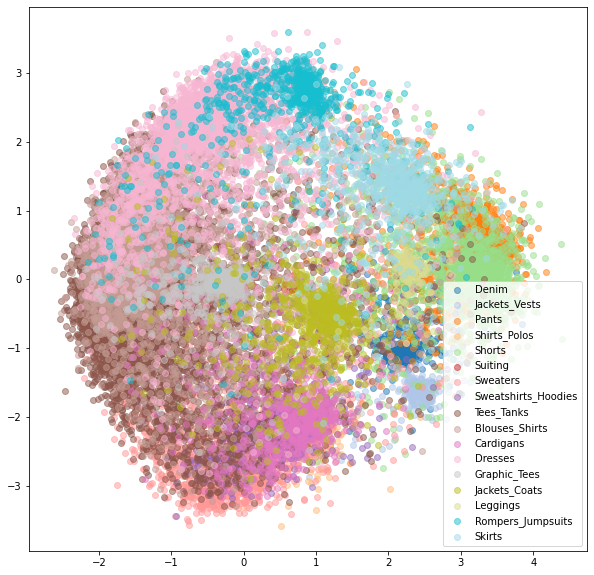

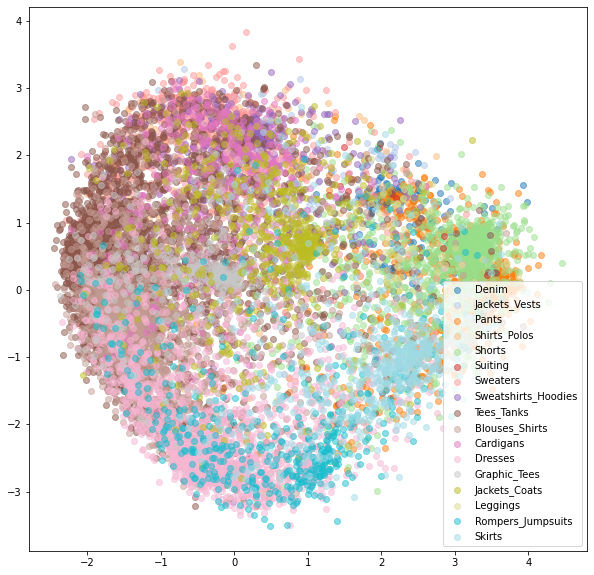

In [0]:
path = os.path.join(models_path,'model_online_triplet_32d.model')
embedding_net = MMFashionEmbeddingResNet101(out_dimensions=32)
model_online_triplet_32d = embedding_net
model_online_triplet_32d.load_state_dict(torch.load(path))
model_online_triplet_32d.eval()
if cuda:
  model_online_triplet_32d.cuda()
train_embeddings, train_labels = extract_embeddings(train_dataloader, model_online_triplet_32d)
plot_embeddings(train_embeddings, train_labels, transform="PCA")
val_embeddings, val_labels = extract_embeddings(query_dataloader, model_online_triplet_32d)
plot_embeddings(val_embeddings, val_labels, transform="PCA")

#### Train and evaluate kNN

In [0]:
train_embeddings, train_labels = extract_embeddings(train_dataloader, model_online_triplet_32d)
val_embeddings, val_labels = extract_embeddings(query_dataloader, model_online_triplet_32d)
print(fitAndEvaluateKNNAlgorithm(train_embeddings, train_labels, val_embeddings, val_labels))

0.6178084118722745


# Task 1 Conclusions

We have been able to analyze the usage of different metric learning techniques.

We have compared the embedding representations resulting from the training of a simple Baseline classification model, resulting in the expected representation.

Afterwards, we have trained Siamese and Triplet Networks to try to find embeddings that separate the different classes. We have tried using 2 dimensions embeddings and 32 dimensions. We also have set the margin parameter to 5 after doing some experimentation.

The results have been analyze from both a subjective and objective perspective.

*   From a subjective perspective, the embeddings projections into a 2D space have been plotted.
*   The resulings embeddings have been used to train and evaluate a simple kNN model that can show how powerful and how capable the model was at separating the different classes.

The results were not so exciting and the kNN tests showed a performance of about 50%, working better with a 32 dimensional embedding.

In a second stage, we have checked the effect of negative mining to see if it helps the model focus on the most difficult pairs or triplets.
The results of negative mining have proved really useful obtaining the best results, both from a subjective and objective point of view.

*   Plots show a much better separation than without negative mining
*   kNN training and evaluation reach a 60% performance, drastically improving the counterparts that do not use negative mining





# **Task2 - Image Retrieval**

For this task we go for a simple retrieval system without doing anything fancy just to try to see the power of metric learning, we will simply learn an embedding from a training set, and afterwards, when a query arrives, an embedding is found and the K closest embeddings in that space are returned for that query. System will be evaluated using recall at different working points.

Ideally, dataset should split images based on item identity but there are too many item ID to split and also hardware limitations make it infeasible.

So, for this task, the best model will be loaded and the model will search for the closest embeddings in that space to the query image and return those as images retrieved.

## Use model for image retrieval, once a query image is received, extract the k closest to it in the embedding space and Evaluate with Recall at different K

Since gallery and query dataset are the only ones that share ids, gallery dataset will be used as dataset to be queried by query dataset

### Develop image retrieval solution

Rewrite get basic item to make it deterministic and avoid random transformation in image while not training

In [0]:
from PIL import Image
import torchvision.transforms as transforms
def get_basic_item(dataset, idx):
    normalize = transforms.Normalize(
      mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([
          transforms.ToTensor(),
          normalize,
    ])
    img = Image.open(os.path.join(dataset.img_path, dataset.img_list[idx]))
    class_id = torch.tensor(dataset.class_ids[idx])
    img_id = dataset.ids[idx]
    width, height = img.size

    if dataset.with_bbox:
      bbox_cor = dataset.bboxes[idx]
      x1 = max(0, int(bbox_cor[0]) - 20)
      y1 = max(0, int(bbox_cor[1]) - 20)
      x2 = int(bbox_cor[2]) + 20
      y2 = int(bbox_cor[3]) + 20
      img = img.crop(box=(x1, y1, x2, y2))

    img.thumbnail(dataset.img_size, Image.ANTIALIAS)
    img = img.convert('RGB')

    label = torch.from_numpy(dataset.labels[idx])
    landmark = []
    # compute the shifted variety

    origin_landmark = dataset.landmarks[idx]
    for i, l in enumerate(origin_landmark):
      if i % 2 == 0:  # x
        l_x = max(0, l - x1)
        l_x = float(l_x) / width * dataset.roi_plane_size
        landmark.append(l_x)
      else:  # y
        l_y = max(0, l - y1)
        l_y = float(l_y) / height * dataset.roi_plane_size
        landmark.append(l_y)

    landmark = torch.from_numpy(np.array(landmark)).float()
    img = transform(img)
    data = {'img': img, 'landmark': landmark, 'id': img_id, 'attr': label, 'target': class_id}
    return data

In [0]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
cuda = torch.cuda.is_available()
from networks import MMFashionEmbeddingResNet101
import numpy as np

def extract_embeddings_with_label_id_and_class_id(dataloader, model):
  with torch.no_grad():
    model.eval()
    embeddings = np.zeros((len(dataloader.dataset), model.out_dimensions))
    ids = np.zeros(len(dataloader.dataset))
    classes_ids = np.zeros(len(dataloader.dataset))
    k = 0
    for loader in dataloader:
      images = loader['img']
      id = loader['id']
      class_id = loader['target']
      if cuda:
        images = images.cuda()
      embeddings[k:k+len(images)] = model(images).data.cpu().numpy()
      ids[k:k+len(images)] = id.numpy()
      classes_ids[k:k+len(images)] = class_id.numpy()
      k += len(images)
  return embeddings, ids, classes_ids

path = os.path.join(models_path,'model_online_triplet_32d.model')
embedding_net = MMFashionEmbeddingResNet101(out_dimensions=32)
model_online_triplet_32d = embedding_net
model_online_triplet_32d.load_state_dict(torch.load(path))
model_online_triplet_32d.eval()
if cuda:
  model_online_triplet_32d.cuda()

query_dataset = InShopDataset(img_path=img_path,
                              img_file=os.path.join(annotations_path,'query_img.txt'),
                              label_file=os.path.join(annotations_path,'query_labels.txt'),
                              id_file=os.path.join(annotations_path,'query_id.txt'),
                              bbox_file=os.path.join(annotations_path,'query_bbox.txt'),
                              landmark_file=os.path.join(annotations_path,'query_landmarks.txt'),
                              img_size=[256, 256],
                              class_mapping=class_mapping)

train_embeddings, _, _ = extract_embeddings_with_label_id_and_class_id(gallery_dataloader, model_online_triplet_32d)

def findKClosestToQuery(embeddings, query_embedding, k):
  return sorted(enumerate(embeddings), key = lambda x : np.linalg.norm(query_embedding-x[1]))[:k]

def extract_closest_image_in_embedding_space(model, idx):
  data = get_basic_item(query_dataset, idx)
  img_path = ds.img_list[idx]
  query_img = mpimg.imread(img_path)
  fig = plt.figure(figsize=(20,20))
  ax1 = fig.add_subplot(1,4,1)
  ax1.title.set_text('Query image')
  ax1.imshow(query_img)

  input_tensor = data['img']
  label_id = data['id']
  class_id = data['target']
  embeddings = model(input_tensor.cuda().unsqueeze(0)).data.cpu().numpy()
  k_closest = findKClosestToQuery(train_embeddings, embeddings[0], len(train_embeddings))
  
  closest = k_closest[0]
  closest_idx = closest[0]

  closest_path = gallery_dataset.img_list[closest_idx - 1]
  closest_img = mpimg.imread(closest_path)
  ax2 = fig.add_subplot(1,4,2)
  ax2.title.set_text('Closest image')
  ax2.imshow(closest_img)

  first_same_class_idx = None
  first_same_class_position = None
  for i, x in enumerate(k_closest):
    if gallery_dataset.class_ids[x[0] - 1] == class_id:
      first_same_class_position = i
      first_same_class_idx = x[0]
      break

  if first_same_class_idx:
    first_same_class_path = gallery_dataset.img_list[first_same_class_idx - 1]
    first_same_class_img = mpimg.imread(first_same_class_path)
    ax3 = fig.add_subplot(1,4,3)
    ax3.title.set_text('First same class image found at {}'.format(first_same_class_position))
    ax3.imshow(first_same_class_img)
  
  first_match_idx = None
  first_match_position = None
  for i, x in enumerate(k_closest):
    if gallery_dataset.ids[x[0] - 1] == label_id:
      first_match_position = i
      first_match_idx = x[0]
      break

  if first_match_idx:
    first_match_path = gallery_dataset.img_list[first_match_idx - 1]
    first_match_img = mpimg.imread(first_match_path)
    ax4 = fig.add_subplot(1,4,4)
    ax4.title.set_text('First match image found at {}'.format(first_match_position))
    ax4.imshow(first_match_img)
  plt.show()

### Test on some images

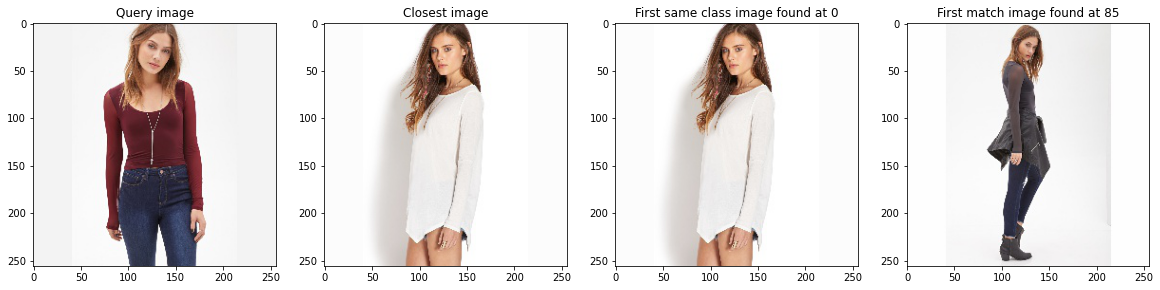

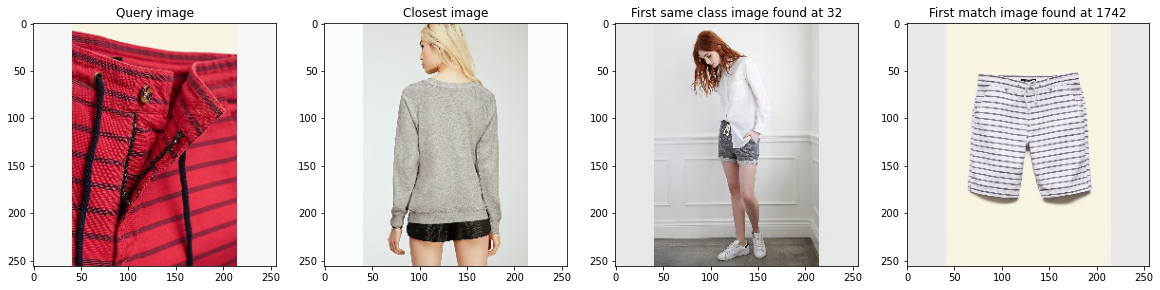

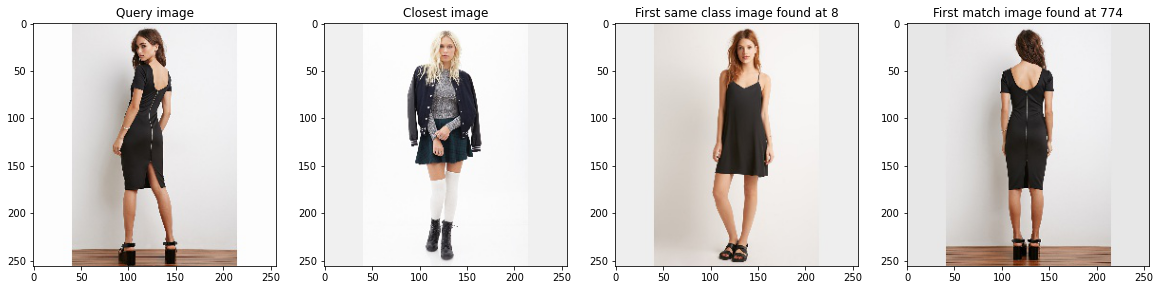

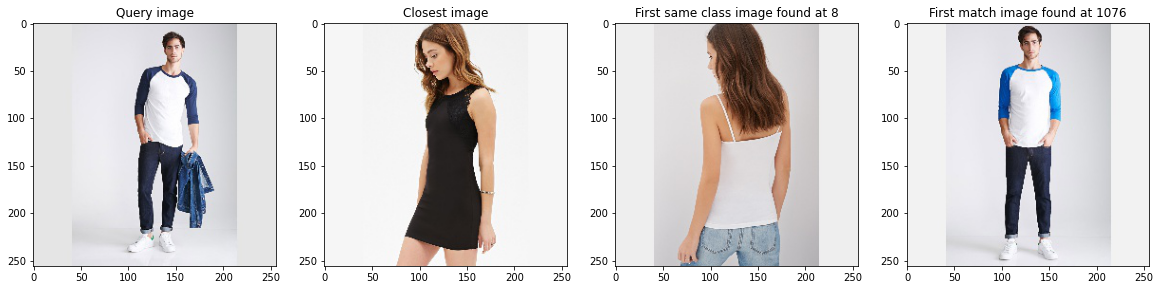

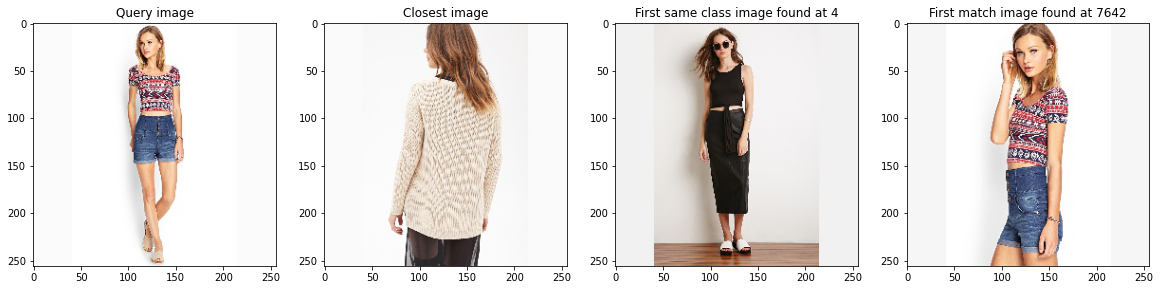

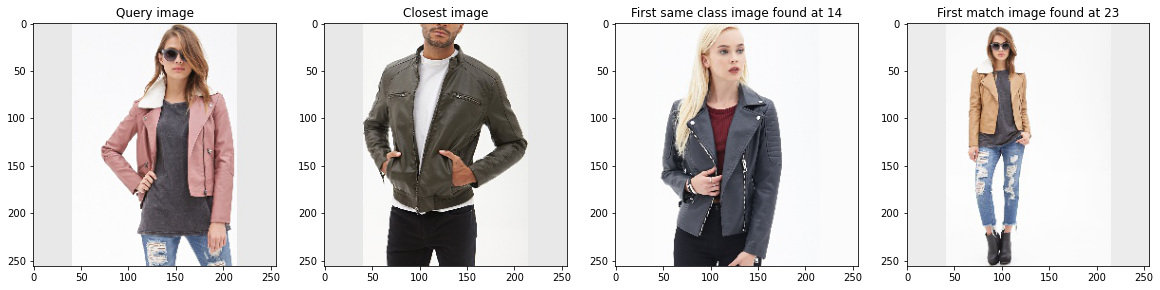

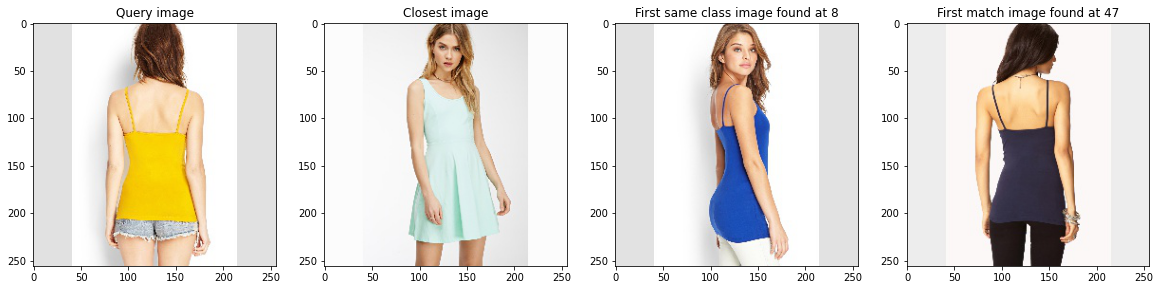

In [0]:
import random
extract_closest_image_in_embedding_space(model_online_triplet_32d, random.randrange(0, 5000, 1))
extract_closest_image_in_embedding_space(model_online_triplet_32d, random.randrange(0, 5000, 1))
extract_closest_image_in_embedding_space(model_online_triplet_32d, random.randrange(0, 5000, 1))
extract_closest_image_in_embedding_space(model_online_triplet_32d, random.randrange(0, 5000, 1))
extract_closest_image_in_embedding_space(model_online_triplet_32d, random.randrange(0, 5000, 1))
extract_closest_image_in_embedding_space(model_online_triplet_32d, random.randrange(0, 5000, 1))
extract_closest_image_in_embedding_space(model_online_triplet_32d, random.randrange(0, 5000, 1))

### Evaluate retrieval systems

Two kind of evaluations will be done:

*   First evaluation: Evaluate Retrieval System looking for images of the same item ID   
*   Second evaluation: Evaluate Retrieval System with a match considered when an image of the same class is returned.

The first problem is a much more difficult task but the second can help assess the implementation of the metric learning framework.



In [0]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
cuda = torch.cuda.is_available()
from networks import MMFashionEmbeddingResNet101, ClassificationNet, SiameseNet
from metrics import AccumulatedAccuracyMetric

def evalRetrievalModelAt(k, train_embeddings, train_labels, query_labels):
  averageRecall = 0
  for idx, query_embedding in enumerate(query_embeddings):
    label = query_labels[idx]
    recall = None
    total = len(list(filter(lambda x: x == label, train_labels)))
    if total:
      count = 0
      closest = findKClosestToQuery(train_embeddings, query_embedding, k)
      for close in closest:
        if train_labels[close[0]] == label:
          count += 1 
      recall = count/total
      averageRecall += recall
  averageRecall = averageRecall / len(query_embeddings)
  return averageRecall

###Evaluate for different k for same item ID

In [0]:
path = os.path.join(models_path,'model_online_triplet_32d.model')
embedding_net = MMFashionEmbeddingResNet101(out_dimensions=32)
model_online_triplet_32d = embedding_net
model_online_triplet_32d.load_state_dict(torch.load(path))
model_online_triplet_32d.eval()
if cuda:
  model_online_triplet_32d.cuda()

gallery_embeddings, gallery_ids, gallery_class_ids = extract_embeddings_with_label_id_and_class_id(gallery_dataloader, model_online_triplet_32d)
query_embeddings, query_ids, query_class_ids = extract_embeddings_with_label_id_and_class_id(query_dataloader, model_online_triplet_32d)

print(evalRetrievalModelAt(10, gallery_embeddings, gallery_ids, query_ids))
print(evalRetrievalModelAt(100, gallery_embeddings, gallery_ids, query_ids))
print(evalRetrievalModelAt(200, gallery_embeddings, gallery_ids, query_ids))
print(evalRetrievalModelAt(500, gallery_embeddings, gallery_ids, query_ids))
print(evalRetrievalModelAt(1000, gallery_embeddings, gallery_ids, query_ids))

0.02985698916848096
0.14492938813423
0.226181695410442
0.38143332586272477
0.5398456692800238


###Evaluate for different k for same class ID

In [0]:
path = os.path.join(models_path,'model_online_triplet_32d.model')
embedding_net = MMFashionEmbeddingResNet101(out_dimensions=32)
model_online_triplet_32d = embedding_net
model_online_triplet_32d.load_state_dict(torch.load(path))
model_online_triplet_32d.eval()
if cuda:
  model_online_triplet_32d.cuda()

gallery_embeddings, gallery_ids, gallery_class_ids = extract_embeddings_with_label_id_and_class_id(gallery_dataloader, model_online_triplet_32d)
query_embeddings, query_ids, query_class_ids = extract_embeddings_with_label_id_and_class_id(query_dataloader, model_online_triplet_32d)

print(evalRetrievalModelAt(10, gallery_embeddings, gallery_class_ids, query_class_ids))
print(evalRetrievalModelAt(100, gallery_embeddings, gallery_class_ids, query_class_ids))
print(evalRetrievalModelAt(200, gallery_embeddings, gallery_class_ids, query_class_ids))
print(evalRetrievalModelAt(500, gallery_embeddings, gallery_class_ids, query_class_ids))
print(evalRetrievalModelAt(1000, gallery_embeddings, gallery_class_ids, query_class_ids))

0.005473580129596859
0.05193785842658421
0.09901587862494439
0.21504027008955642
0.3554567772224401
